### Importing necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Getting New York JSON file

In [2]:
with open(r'C:\Users\MONSTER\Desktop\ny.json') as json_data:
    newyork_data = json.load(json_data)

### Exploring JSON file

In [3]:
neighborhoods_data = newyork_data['features']

In [4]:
neighborhoods_data[0]

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

### Creating a suitable dataframe

In [5]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### Using folium library to create a map

In [9]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [10]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Narrowing down to Manhattan

In [11]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [12]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [13]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [14]:
CLIENT_ID = '05Y4VHYPLZQYH2NXVX5CDSII0FNABH54BRFIFL02GNRCXP0N' # your Foursquare ID
CLIENT_SECRET = 'RJMXBRLBG2K0VKK0RZEBDQYYKSYUEY4LJUCLSLBRUIZQL3Y3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 05Y4VHYPLZQYH2NXVX5CDSII0FNABH54BRFIFL02GNRCXP0N
CLIENT_SECRET:RJMXBRLBG2K0VKK0RZEBDQYYKSYUEY4LJUCLSLBRUIZQL3Y3


In [15]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

In [16]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


### Discovering 100 venues with radius 500 meters

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
LIMIT = 100
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [19]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3176, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [20]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,70,70,70,70,70,70
Carnegie Hill,90,90,90,90,90,90
Central Harlem,41,41,41,41,41,41
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,41,41,41,41,41,41
East Village,100,100,100,100,100,100


Here, found out that some of the neighborhoods do not have 100 venues in 500 meters

In [21]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 329 uniques categories.


In [22]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop

## Preparing data frame that only has related columns

In [25]:
m = manhattan_onehot.groupby('Neighborhood').sum().reset_index()

In [26]:
gym = m[['Neighborhood','Gym','Gym / Fitness Center','Boxing Gym','Climbing Gym','Cycle Studio','Gym Pool','Gymnastics Gym','Supplement Shop']]

In [27]:
gym

,Neighborhood,Gym,Gym / Fitness Center,Boxing Gym,Climbing Gym,Cycle Studio,Gym Pool,Gymnastics Gym,Supplement Shop
0,Battery Park City,4,0,0,0,0,0,0,0
1,Carnegie Hill,3,3,0,0,0,0,0,0
2,Central Harlem,1,1,0,0,1,0,0,0
3,Chelsea,1,2,0,0,2,0,0,0
4,Chinatown,0,0,0,0,0,0,0,0
5,Civic Center,2,3,1,0,0,0,0,0
6,Clinton,3,5,0,0,0,0,0,0
7,East Harlem,1,0,0,0,0,0,0,0
8,East Village,0,0,0,0,0,0,0,0
9,Financial District,2,3,0,0,1,0,0,0


In [28]:
gym['Total'] = gym.sum(axis=1)

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
manhattan_grouped.shape

(40, 330)

In [30]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.09
1          Hotel  0.07
2            Gym  0.06
3  Memorial Site  0.04
4    Coffee Shop  0.04


----Carnegie Hill----
                  venue  freq
0           Coffee Shop  0.08
1                  Café  0.06
2        Cosmetics Shop  0.03
3             Bookstore  0.03
4  Gym / Fitness Center  0.03


----Central Harlem----
                 venue  freq
0    French Restaurant  0.05
1   African Restaurant  0.05
2  American Restaurant  0.05
3                  Bar  0.05
4   Chinese Restaurant  0.05


----Chelsea----
                 venue  freq
0          Coffee Shop  0.09
1          Art Gallery  0.05
2   Italian Restaurant  0.04
3  American Restaurant  0.04
4       Ice Cream Shop  0.03


----Chinatown----
                 venue  freq
0   Chinese Restaurant  0.09
1         Cocktail Bar  0.05
2  American Restaurant  0.04
3               Bakery  0.04
4         Dessert Shop  0.03


----Civic Center----
               venue  fr

## Finding the most common venues for each neighborhood

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Gym,Boat or Ferry,Coffee Shop,Memorial Site,Wine Shop,Gourmet Shop,Mexican Restaurant,Shopping Mall
1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Gym,Pizza Place,Bookstore,Bakery,Japanese Restaurant,Cosmetics Shop,Italian Restaurant
2,Central Harlem,Seafood Restaurant,Bar,African Restaurant,American Restaurant,Chinese Restaurant,French Restaurant,Dessert Shop,Library,Gym / Fitness Center,Beer Bar
3,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Italian Restaurant,Ice Cream Shop,Bakery,Gym / Fitness Center,Speakeasy,Hotel,Nightclub
4,Chinatown,Chinese Restaurant,Cocktail Bar,Bakery,American Restaurant,Spa,Dessert Shop,Salon / Barbershop,Vietnamese Restaurant,Hotpot Restaurant,Optical Shop


## Clustering Neighborhoods

In [33]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 1, 4, 0, 1, 4, 1, 1])

In [34]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data


manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,3,Sandwich Place,Gym,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Shopping Mall,Seafood Restaurant,Pizza Place
1,Manhattan,Chinatown,40.715618,-73.994279,4,Chinese Restaurant,Cocktail Bar,Bakery,American Restaurant,Spa,Dessert Shop,Salon / Barbershop,Vietnamese Restaurant,Hotpot Restaurant,Optical Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Grocery Store,Deli / Bodega,Chinese Restaurant,Mobile Phone Shop,Mexican Restaurant,Supplement Shop,Coffee Shop,Latin American Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,4,Mexican Restaurant,Café,Lounge,Pizza Place,Restaurant,Chinese Restaurant,Park,Bakery,American Restaurant,Frozen Yogurt Shop
4,Manhattan,Hamilton Heights,40.823604,-73.949688,4,Pizza Place,Café,Coffee Shop,Deli / Bodega,Mexican Restaurant,Sushi Restaurant,Cocktail Bar,Sandwich Place,Bakery,Yoga Studio


In [35]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [36]:
cluster0 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

In [37]:
cluster1 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

In [38]:
cluster2 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

In [39]:
cluster3 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

In [40]:
cluster4 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

In [41]:
cluster0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Central Harlem,Seafood Restaurant,Bar,African Restaurant,American Restaurant,Chinese Restaurant,French Restaurant,Dessert Shop,Library,Gym / Fitness Center,Beer Bar
13,Lincoln Square,Plaza,Café,Italian Restaurant,Performing Arts Venue,Theater,Concert Hall,Wine Shop,American Restaurant,Gym / Fitness Center,Indie Movie Theater
21,Tribeca,Italian Restaurant,Park,Café,Spa,Wine Bar,Coffee Shop,American Restaurant,Men's Store,Burger Joint,Skate Park
24,West Village,Italian Restaurant,New American Restaurant,Wine Bar,American Restaurant,Bakery,Park,Cocktail Bar,Jazz Club,Gastropub,Coffee Shop
26,Morningside Heights,Park,Bookstore,Coffee Shop,American Restaurant,Deli / Bodega,Burger Joint,New American Restaurant,Outdoor Sculpture,Grocery Store,Greek Restaurant
28,Battery Park City,Park,Hotel,Gym,Boat or Ferry,Coffee Shop,Memorial Site,Wine Shop,Gourmet Shop,Mexican Restaurant,Shopping Mall
32,Civic Center,Coffee Shop,French Restaurant,Hotel,Cocktail Bar,Yoga Studio,Park,Spa,Sushi Restaurant,American Restaurant,Gym / Fitness Center
35,Turtle Bay,Italian Restaurant,Coffee Shop,Hotel,Café,Sushi Restaurant,Japanese Restaurant,French Restaurant,Deli / Bodega,Park,Wine Bar
39,Hudson Yards,American Restaurant,Hotel,Gym / Fitness Center,Italian Restaurant,Dog Run,Spanish Restaurant,Burger Joint,Café,Thai Restaurant,Gym


## Sorting and eleminating sports kind of data

In [42]:
gym

,Neighborhood,Gym,Gym / Fitness Center,Boxing Gym,Climbing Gym,Cycle Studio,Gym Pool,Gymnastics Gym,Supplement Shop,Total
0,Battery Park City,4,0,0,0,0,0,0,0,4
1,Carnegie Hill,3,3,0,0,0,0,0,0,6
2,Central Harlem,1,1,0,0,1,0,0,0,3
3,Chelsea,1,2,0,0,2,0,0,0,5
4,Chinatown,0,0,0,0,0,0,0,0,0
5,Civic Center,2,3,1,0,0,0,0,0,6
6,Clinton,3,5,0,0,0,0,0,0,8
7,East Harlem,1,0,0,0,0,0,0,0,1
8,East Village,0,0,0,0,0,0,0,0,0
9,Financial District,2,3,0,0,1,0,0,0,6


In [61]:
gym_sorted = gym.sort_values(by='Total', ascending = False)

In [62]:
gym_sorted.head()

,Neighborhood,Gym,Gym / Fitness Center,Boxing Gym,Climbing Gym,Cycle Studio,Gym Pool,Gymnastics Gym,Supplement Shop,Total
31,Sutton Place,4,5,0,0,1,0,0,0,10
10,Flatiron,2,4,0,0,3,0,0,0,9
16,Lenox Hill,3,3,0,0,2,0,0,1,9
39,Yorkville,6,1,0,0,0,0,1,0,8
17,Lincoln Square,2,3,0,1,2,0,0,0,8


### Importing necessary libraries

In [43]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

### Getting only total numbers for each neighborhood

In [45]:
gymsum = gym[['Neighborhood','Total']]
gymsum.head()

,Neighborhood,Total
0,Battery Park City,4
1,Carnegie Hill,6
2,Central Harlem,3
3,Chelsea,5
4,Chinatown,0


### Sorting by total numbers in order to create a effective bar chart

In [59]:
gymsum_sorted = gymsum.sort_values(by='Total', ascending = False)

In [60]:
gymsum_sorted.head()

,Neighborhood,Total
31,Sutton Place,10
10,Flatiron,9
16,Lenox Hill,9
39,Yorkville,8
17,Lincoln Square,8


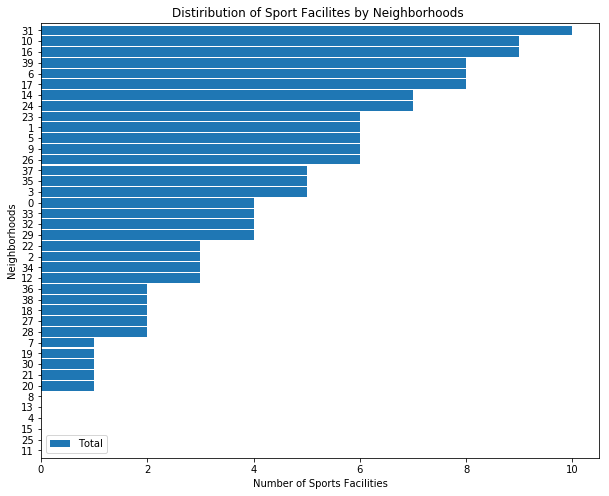

In [49]:

gymsum_sorted.plot(kind='barh', width = 0.9, figsize=(10, 8))

plt.ylabel('Neighborhoods') # add to x-label to the plot
plt.xlabel('Number of Sports Facilities') # add y-label to the plot
plt.title('Distiribution of Sport Facilites by Neighborhoods ') # add title to the plot

plt.show()

### Changing index names to have a clear vision

In [50]:
a = gymsum_sorted.set_index('Neighborhood')

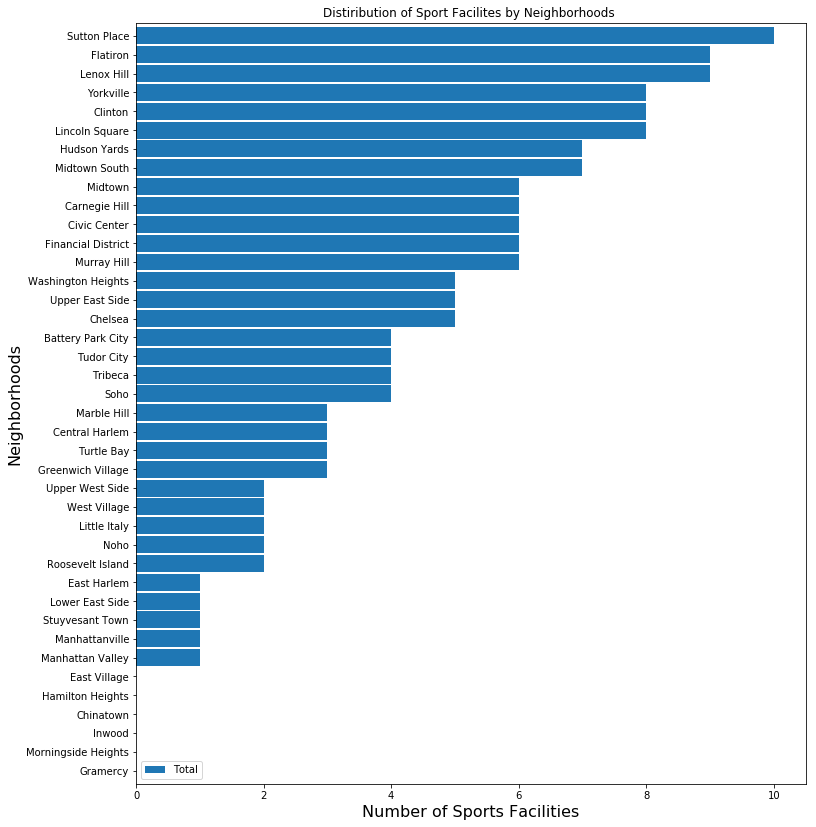

In [51]:
a.plot(kind='barh', width = 0.9, figsize=(12, 14))

plt.ylabel('Neighborhoods', size = 16) # add to x-label to the plot
plt.xlabel('Number of Sports Facilities', size = 16) # add y-label to the plot
plt.title('Distiribution of Sport Facilites by Neighborhoods ') # add title to the plot

plt.show()

Now, we can easily distinguish our top candidates.

In [53]:
a.tail()

,Total
Neighborhood,
Clinton,8
Yorkville,8
Lenox Hill,9
Flatiron,9
Sutton Place,10


# Analyzing top 5 neighborhoods one by one

In [54]:
manhattan_merged.loc[manhattan_merged['Neighborhood'] == 'Sutton Place']

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,Manhattan,Sutton Place,40.76028,-73.963556,1,Gym / Fitness Center,Italian Restaurant,Coffee Shop,Pizza Place,Gym,Park,Furniture / Home Store,Bar,Beer Bar,Beer Garden


In [55]:
manhattan_merged.loc[manhattan_merged['Neighborhood'] == 'Flatiron']

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,Manhattan,Flatiron,40.739673,-73.990947,1,New American Restaurant,Gym / Fitness Center,Japanese Restaurant,Italian Restaurant,American Restaurant,Furniture / Home Store,Café,Cycle Studio,Spa,Vegetarian / Vegan Restaurant


In [56]:
manhattan_merged.loc[manhattan_merged['Neighborhood'] == 'Lenox Hill']

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Manhattan,Lenox Hill,40.768113,-73.95886,1,Italian Restaurant,Coffee Shop,Sushi Restaurant,Pizza Place,Cocktail Bar,Café,Burger Joint,Gym,Gym / Fitness Center,Playground


In [57]:
manhattan_merged.loc[manhattan_merged['Neighborhood'] == 'Yorkville']

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Manhattan,Yorkville,40.77593,-73.947118,1,Italian Restaurant,Coffee Shop,Gym,Bar,Deli / Bodega,Pizza Place,Sushi Restaurant,Wine Shop,Diner,Japanese Restaurant


In [58]:
manhattan_merged.loc[manhattan_merged['Neighborhood'] == 'Clinton']

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Manhattan,Clinton,40.759101,-73.996119,1,Italian Restaurant,Gym / Fitness Center,Theater,Coffee Shop,Spa,Thai Restaurant,Cocktail Bar,Sandwich Place,Gym,Hotel


In [65]:
gym

,Neighborhood,Gym,Gym / Fitness Center,Boxing Gym,Climbing Gym,Cycle Studio,Gym Pool,Gymnastics Gym,Supplement Shop,Total
0,Battery Park City,4,0,0,0,0,0,0,0,4
1,Carnegie Hill,3,3,0,0,0,0,0,0,6
2,Central Harlem,1,1,0,0,1,0,0,0,3
3,Chelsea,1,2,0,0,2,0,0,0,5
4,Chinatown,0,0,0,0,0,0,0,0,0
5,Civic Center,2,3,1,0,0,0,0,0,6
6,Clinton,3,5,0,0,0,0,0,0,8
7,East Harlem,1,0,0,0,0,0,0,0,1
8,East Village,0,0,0,0,0,0,0,0,0
9,Financial District,2,3,0,0,1,0,0,0,6


## Distinguishing neighborhoods that already has a supplement shop

In [69]:
gym.loc[gym['Supplement Shop'] > 0]

,Neighborhood,Gym,Gym / Fitness Center,Boxing Gym,Climbing Gym,Cycle Studio,Gym Pool,Gymnastics Gym,Supplement Shop,Total
16,Lenox Hill,3,3,0,0,2,0,0,1,9
22,Marble Hill,2,0,0,0,0,0,0,1,3
37,Washington Heights,2,1,0,0,0,0,0,2,5


In [73]:
b = gym[['Neighborhood', 'Supplement Shop']]

In [75]:
c = b.loc[b['Supplement Shop'] > 0]

In [76]:
c

,Neighborhood,Supplement Shop
16,Lenox Hill,1
22,Marble Hill,1
37,Washington Heights,2
